# Weißseespitze_AWS_correction
Author: Anna Baldo - Master thesis - University of Innsbruck & IGF - anna.baldo@student.uibk.ac.at <br>
Based on the work of: Federico Covi - Site J AWS Raw Data Correction - Jan 2020 - Fairbanks, AK

In [1]:
# import required modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
# Folder pattern where all the datasets are:
# Data available for download on https://www.pangaea.de/
filepath = "your own filepath/20171031-20231031_WSS_gesamt.dat"
ds = pd.read_csv(filepath, sep = ',', skiprows=[0,2,3], parse_dates=True, low_memory=False)

# set date as index and fix the format. Time is in UTC (checked)
ds.set_index('TIMESTAMP', inplace=True)
ds.index = pd.to_datetime(ds.index, format='%Y-%m-%d %H:%M:%S')

# convert accidental strings in numeric values
ds = ds.astype(float)
# drop 'Rain_Tot' because it is always 0
ds.drop(columns=['Rain_Tot'], inplace=True)

# Make sure that all NaN values are `np.nan` not `'NAN'` (strings)
ds_resample = ds.resample('10min').mean()
ds_resample = ds_resample.replace('NAN', np.nan)

In [3]:
# Plot first and TIMESTAMP in the data
print('Start date: ', ds.index[0])
print('End date: ', ds.index[-1])

Start date:  2017-10-31 14:10:00
End date:  2023-10-31 14:00:00


In [4]:
# create CORRECTED dataset with regular time interval of 10 minutes
ds_CORR = ds_resample.copy()
ds_CORR = ds_CORR.astype(float)

## 1) First correction round: malfunctioning errors

### Air temeprature

In [5]:
#Detect the subset of data where sensors show error values or wrong estimates:
Tair_malfunct = pd.concat([ds_resample.Tair_Avg.loc[(ds_resample.Tair_Avg.values.astype(np.float64) == -9999) | 
                            (ds_resample.Tair_Avg.values.astype(np.float64) == -40.0) |
                            (ds_resample.Tair_Avg.isnull()) |
                            (ds_resample.Tair_Avg.values.astype(np.float64) < -40.0) |
                            (ds_resample.Tair_Avg.values.astype(np.float64) > 60.0)],                                
                          ds_resample.Batt_Min.loc[(ds_resample.Batt_Min.values.astype(np.float64) == 0.0)]])
#number of incidences
n_Tair_malfunct = len(Tair_malfunct)
print('Number of incidences: ', n_Tair_malfunct)
print('Tair is NaN: %d | %.2f%%' % (len(ds_resample.Tair_Avg.loc[ds_resample.Tair_Avg.isnull()]),
                                    100*len(ds_resample.Tair_Avg.loc[ds_resample.Tair_Avg.isnull()])/len(ds_resample.Tair_Avg)))

# as the only error values are nan, the "corrected" column has the same data as the Tair_Avg
ds_CORR['Tair_Avg_Corr'] = ds_resample.Tair_Avg
# also create column with interpolated data
ds_CORR['Tair_Avg_Interpol'] = ds_resample.Tair_Avg.interpolate(method="linear", limit_direction ='forward')

Number of incidences:  13795
Tair is NaN: 13795 | 4.37%


### Relative Humidity

In [6]:
#Detect the subset of data where sensors show wrong estimates:
RH_malfunct = ds_resample.Hum_Avg.loc[(ds_resample.Hum_Avg.values.astype(np.float64) > 100.0) | 
                                     (ds_resample.Hum_Avg.values.astype(np.float64) == 0.0) |
                                     (ds_resample.Hum_Avg.isnull())]
#number of incidences
n_RH_malfunct = len(RH_malfunct)
print('Number of incidences: ', n_RH_malfunct)
print('RH is NaN: %d | %.2f%%' % (len(ds_resample.Hum_Avg.loc[ds_resample.Hum_Avg.isnull()]),
                                    100*len(ds_resample.Hum_Avg.loc[ds_resample.Hum_Avg.isnull()])/len(ds_resample.Hum_Avg)))
print('RH > 100%%: %d | %.2f%%' % (len(ds_resample.Hum_Avg[ds_resample.Hum_Avg > 100]),
                                   100*len(ds_resample.Hum_Avg[ds_resample.Hum_Avg > 100])/len(ds_resample.Hum_Avg)))
print('RH = 100%%: %d | %.2f%%' % (len(ds_resample.Hum_Avg[ds_resample.Hum_Avg == 100]),
                                   100*len(ds_resample.Hum_Avg[ds_resample.Hum_Avg == 100])/len(ds_resample.Hum_Avg)))
print('RH < 0%%: %d | %.2f%%' % (len(ds_resample.Hum_Avg[ds_resample.Hum_Avg < 0]),
                                 100*len(ds_resample.Hum_Avg[ds_resample.Hum_Avg < 0])/len(ds_resample.Hum_Avg)))
print('RH = 0%%: %d | %.2f%%' % (len(ds_resample.Hum_Avg[ds_resample.Hum_Avg == 0]),
                                 100*len(ds_resample.Hum_Avg[ds_resample.Hum_Avg == 0])/len(ds_resample.Hum_Avg)))

#correct the values over 100 to 100
ds_CORR['Hum_Avg_Corr'] = ds_resample.Hum_Avg.copy().to_frame()
ds_CORR.Hum_Avg_Corr[ds_CORR.Hum_Avg_Corr.values.astype(np.float64) < 0] = 0.0
ds_CORR.Hum_Avg_Corr[ds_CORR.Hum_Avg_Corr.values.astype(np.float64) > 100] = 100.0

# and interpolate in gaps
ds_CORR['Hum_Avg_Interpol'] = ds_resample.Hum_Avg.copy().to_frame()
ds_CORR.Hum_Avg_Interpol = ds_resample.Hum_Avg.interpolate(method="linear", limit_direction ='forward')

Number of incidences:  16815
RH is NaN: 16783 | 5.32%
RH > 100%: 32 | 0.01%
RH = 100%: 0 | 0.00%
RH < 0%: 0 | 0.00%
RH = 0%: 0 | 0.00%


### Wind speed and direction

In [7]:
Wdir_malfunct = ds_resample.Wdir.loc[(ds_resample.Wdir.values.astype(np.float64) == -9999) |
                                     (ds_resample.Wdir.isnull()) |
                                     (ds_resample.Wdir.values.astype(np.float64) > 360) |
                                     (ds_resample.Wdir.values.astype(np.float64) < 0)]
    
Wspeed_malfunct = ds_resample.Wspeed.loc[(ds_resample.Wspeed.values.astype(np.float64) == -9999) |
                                         (ds_resample.Wspeed.isnull()) |
                                         (ds_resample.Wspeed.values.astype(np.float64) < 0)]

# NOT AVAILABLE
#if smaller time interval use Std_Wdir < threshold to flag as error:
# thresh = 1
# Wspeed_malfunct_2 = ds.Wspeed.loc[ds.Std_Wdir.values.astype(np.float64) <= thresh]

#number of incidences
n_Wdir_malfunct = len(Wdir_malfunct)
n_Wspeed_malfunct = len(Wspeed_malfunct)

print('Number of incidences: Wind speed:', n_Wspeed_malfunct, '| Wind direction: ', n_Wdir_malfunct)
print(' ')
print('Wspeed is NaN: %d | %.2f%%' % (len(ds_resample.Wspeed.loc[ds_resample.Wspeed.isnull()]),
                                    100*len(ds_resample.Wspeed.loc[ds_resample.Wspeed.isnull()])/len(ds_resample.Wspeed)))
print('Wspeed < 0: %d, %.2f%%' % (len(ds_resample.Wspeed[ds_resample.Wspeed < 0]),
                                  100*len(ds_resample.Wspeed[ds_resample.Wspeed < 0])/len(ds_resample.Wspeed)))
print(' ')
print('Wdir is NaN: %d | %.2f%%' % (len(ds_resample.Wdir.loc[ds_resample.Wdir.isnull()]),
                                    100*len(ds_resample.Wdir.loc[ds_resample.Wdir.isnull()])/len(ds_resample.Wdir)))
print('Wdir < 0: %d, %.2f%%' % (len(ds_resample.Wdir[ds_resample.Wdir < 0]),
                                  100*len(ds_resample.Wdir[ds_resample.Wdir < 0])/len(ds_resample.Wdir)))
print('Wdir > 360: %d, %.2f%%' % (len(ds_resample.Wdir[ds_resample.Wdir > 360]),
                                  100*len(ds_resample.Wdir[ds_resample.Wdir > 360])/len(ds_resample.Wdir)))

# Riming
print('Wspeed = 0: %d, %.2f%%' % (len(ds_resample.Wspeed[ds_resample.Wspeed == 0]),
                                  100*len(ds_resample.Wspeed[ds_resample.Wspeed == 0])/len(ds_resample.Wspeed)))

# Set to NaN all times that Wspd = 0 for more than 1 hour consecutive
wspd = ds_resample.Wspeed.copy()
ii = 0
while ii < len(wspd):
    if np.sum(wspd[wspd.index[ii]: wspd.index[ii] + pd.Timedelta(hours=1)]) == 0:
        wspd[wspd.index[ii]: wspd.index[ii] + pd.Timedelta(hours=1)] = np.nan
        ii += len(wspd[wspd.index[ii]: wspd.index[ii] + pd.Timedelta(hours=1)])
        while wspd[wspd.index[ii]] == 0:  # what does this part do? I thought it was already done above
            wspd[wspd.index[ii]] = np.nan
            ii += 1
    else:
        ii += 1

# assign to corrected dataframe
ds_CORR['Wspeed_Corr'] = ds_resample.Wspeed.copy()
ds_CORR.Wspeed_Corr = wspd
print('Wspeed CORR = 0: %d, %.2f%%' % (len(ds_CORR.Wspeed_Corr[ds_CORR.Wspeed_Corr == 0]),
                                  100*len(ds_CORR.Wspeed_Corr[ds_CORR.Wspeed_Corr == 0])/len(ds_CORR.Wspeed_Corr)))

# set to NaN all 3 consecutive (or more) wind direction measurements that fall within a defined threshold
dm = 3  # define threshold (e.g. sensor resolution = 3 deg, maybe it's too much?)

ds_CORR['Wdir_Corr'] = ds_resample.Wdir.copy()
ref = ds_resample.Wdir
for ind in range(2, len(ref)-2):
    if ref[ind+1]-dm <= ref[ind] <= ref[ind+1]+dm and ref[ind+2]-dm <= ref[ind] <= ref[ind+2]+dm:
        ds_CORR.Wdir_Corr[ind] = np.nan
    elif ref[ind-1]-dm <= ref[ind] <= ref[ind-1]+dm and ref[ind+1]-dm <= ref[ind] <= ref[ind+1]+dm:
        ds_CORR.Wdir_Corr[ind] = np.nan
    elif ref[ind-1]-dm <= ref[ind] <= ref[ind-1]+dm and ref[ind-2]-dm <= ref[ind] <= ref[ind-2]+dm:
        ds_CORR.Wdir_Corr[ind] = np.nan
        
print('number of values corrected:')
print('W speed: %d | %d%%' % (len(ds_CORR.Wspeed_Corr[ds_CORR.Wspeed_Corr != ds_resample.Wspeed]),
                              100*len(ds_CORR.Wspeed_Corr[ds_CORR.Wspeed_Corr != ds_resample.Wspeed])/len(ds_CORR.Wspeed_Corr)))
print('W dir: %d | %d%%' % (len(ds_CORR.Wdir_Corr[ds_CORR.Wdir_Corr != ds_resample.Wdir]),
                            100*len(ds_CORR.Wdir_Corr[ds_CORR.Wdir_Corr != ds_resample.Wdir])/len(ds_CORR.Wdir_Corr)))
print('W speed mean: CORR = %.2f m/s | RAW %.2f m/s' % (np.nanmean(ds_CORR.Wspeed_Corr), np.nanmean(ds_resample.Wspeed)))
print('W dir mean: CORR = %.2f deg | RAW %.2f deg' % (np.nanmean(ds_CORR.Wdir_Corr), np.nanmean(ds_resample.Wdir)))

Number of incidences: Wind speed: 13795 | Wind direction:  13795
 
Wspeed is NaN: 13795 | 4.37%
Wspeed < 0: 0, 0.00%
 
Wdir is NaN: 13795 | 4.37%
Wdir < 0: 0, 0.00%
Wdir > 360: 0, 0.00%
Wspeed = 0: 22776, 7.22%
Wspeed CORR = 0: 1065, 0.34%
number of values corrected:
W speed: 35506 | 11%
W dir: 107986 | 34%
W speed mean: CORR = 5.48 m/s | RAW 5.09 m/s
W dir mean: CORR = 211.61 deg | RAW 184.85 deg


### SW radiation

In [8]:
#check for nan values, SW_out > SW_in
SW_malfunct = pd.concat([ds_resample[['SWin_Avg','SWout_Avg']].loc[(ds_resample['SWin_Avg'].isnull())],
                         ds_resample[['SWin_Avg','SWout_Avg']].loc[(ds_resample['SWout_Avg'].isnull())]])

#number of incidences
n_SW_malfunct = len(SW_malfunct)

print('Number of incidences: ', n_SW_malfunct)
print('SWin is NaN: %d | %.2f%%' % (len(ds_resample.SWin_Avg.loc[ds_resample.SWin_Avg.isnull()]),
                                    100*len(ds_resample.SWin_Avg.loc[ds_resample.SWin_Avg.isnull()])/len(ds_resample.SWin_Avg)))
print('SWout is NaN: %d | %.2f%%' % (len(ds_resample.SWout_Avg.loc[ds_resample.SWout_Avg.isnull()]),
                                    100*len(ds_resample.SWout_Avg.loc[ds_resample.SWout_Avg.isnull()])/len(ds_resample.SWout_Avg)))

print('Values < 0 in raw data: SWin = %d, %.0f%% | SWout = %d, %.0f%%' 
      % (len(ds_resample.SWin_Avg[ds_resample.SWin_Avg < 0]), 100*len(ds_resample.SWin_Avg[ds_resample.SWin_Avg < 0])/len(ds_resample.SWin_Avg),
      len(ds_resample.SWout_Avg[ds_resample.SWout_Avg < 0]), 100*len(ds_resample.SWout_Avg[ds_resample.SWout_Avg < 0])/len(ds_resample.SWout_Avg))) 

# reset negative values to 0 PAIRWISE:
ds_CORR[['SWin_Avg_Corr', 'SWout_Avg_Corr']] = ds_resample[['SWin_Avg', 'SWout_Avg']].clip(lower=0)
ds_CORR.loc[ds_CORR['SWin_Avg_Corr'] == 0] = ds_CORR.loc[ds_CORR['SWin_Avg_Corr'] == 0].assign(SWout_Avg_Corr=0)
ds_CORR.loc[ds_CORR['SWout_Avg_Corr'] == 0] = ds_CORR.loc[ds_CORR['SWout_Avg_Corr'] == 0].assign(SWin_Avg_Corr=0)

# should be zero
print('Values < 0 in CORR data: SWin = %d, %.0f%% | SWout = %d, %.0f%%' 
      % (len(ds_CORR.SWin_Avg_Corr[ds_CORR.SWin_Avg_Corr < 0]),
         100*len(ds_CORR.SWin_Avg_Corr[ds_CORR.SWin_Avg_Corr < 0])/len(ds_CORR.SWin_Avg_Corr),
      len(ds_CORR.SWout_Avg_Corr[ds_CORR.SWout_Avg_Corr < 0]),
         100*len(ds_CORR.SWout_Avg_Corr[ds_CORR.SWout_Avg_Corr < 0])/len(ds_CORR.SWout_Avg_Corr))) 

# SWout > SWin
print('SWout > SWin in all conditions: %d | %.2f%%' % (len(ds_CORR[['SWin_Avg_Corr','SWout_Avg_Corr']].loc[ds_CORR.SWout_Avg_Corr.values.astype(np.float64) > ds_CORR.SWin_Avg_Corr.values.astype(np.float64)]),
                                    100*len(ds_CORR[['SWin_Avg_Corr','SWout_Avg_Corr']].loc[ds_CORR.SWout_Avg_Corr.values.astype(np.float64) > ds_CORR.SWin_Avg_Corr.values.astype(np.float64)])/len(ds_CORR.SWin_Avg_Corr)))

# Check when SWout > SWin during the day (use 20 W m-2 to define day time)
sw_var = ds_CORR.SWout_Avg_Corr[(ds_CORR.SWin_Avg_Corr > 20) | (ds_CORR.SWout_Avg_Corr > 20)] - ds_CORR.SWin_Avg_Corr[(ds_CORR.SWin_Avg_Corr > 20) | (ds_CORR.SWout_Avg_Corr > 20)]
print('SWout > SWin during daytime: %d, %.2f%%' % (len(sw_var[sw_var > 0]), 100*len(sw_var[sw_var > 0])/len(sw_var)))

ds_CORR['SWout_flag'] = 0
ds_CORR.loc[ds_CORR['SWout_Avg_Corr'].values.astype(np.float64) >  ds_CORR['SWin_Avg_Corr'].values.astype(np.float64)] = ds_CORR.loc[ds_CORR['SWout_Avg_Corr'].values.astype(np.float64) >  ds_CORR['SWin_Avg_Corr'].values.astype(np.float64)].assign(SWout_flag = 1)

# Check results of correction
print('Flagged data in all conditions: %d | %.2f%%' % (len(ds_CORR['SWout_flag'].loc[ds_CORR.SWout_flag == 1]),
                                    100*len(ds_CORR['SWout_flag'].loc[ds_CORR.SWout_flag == 1])/len(ds_CORR.SWout_flag)))

# linearly interpolate corrected data
ds_CORR['SWin_Avg_Interpol'] = ds_CORR.SWin_Avg_Corr.interpolate(method="linear", limit_direction ='both')
ds_CORR['SWout_Avg_Interpol'] = ds_CORR.SWout_Avg_Corr.interpolate(method="linear", limit_direction='both')

# recompute albedo with the corrected SWin and SWout
ds_CORR['Albedo_Avg_Corr'] = ds_CORR.SWout_Avg_Corr / ds_CORR.SWin_Avg_Corr

# calculate daily albedo as ratio of SWOUT/SWIN
# daily_SW = ds_CORR[['SWin_Avg_Corr', 'SWout_Avg_Corr']].resample('24h').sum()
# daily_albedo = pd.DataFrame(daily_SW['SWout_Avg_Corr']/daily_SW['SWin_Avg_Corr'], columns=['albedo']) 

Number of incidences:  27591
SWin is NaN: 13795 | 4.37%
SWout is NaN: 13796 | 4.37%
Values < 0 in raw data: SWin = 131021, 42% | SWout = 58691, 19%
Values < 0 in CORR data: SWin = 0, 0% | SWout = 0, 0%
SWout > SWin in all conditions: 30160 | 9.56%
SWout > SWin during daytime: 17548, 12.22%
Flagged data in all conditions: 30160 | 9.56%


### LW radiation

In [9]:
print('LWinCor is NaN: %d | %.2f%%' % (len(ds_resample.LWinCor_Avg.loc[ds_resample.LWinCor_Avg.isnull()]),
                                    100*len(ds_resample.LWinCor_Avg.loc[ds_resample.LWinCor_Avg.isnull()])/len(ds_resample.LWinCor_Avg)))
print('LWoutCor is NaN: %d | %.2f%%' % (len(ds_resample.LWoutCor_Avg.loc[ds_resample.LWoutCor_Avg.isnull()]),
                                    100*len(ds_resample.LWoutCor_Avg.loc[ds_resample.LWoutCor_Avg.isnull()])/len(ds_resample.LWoutCor_Avg)))

print('LWinCor min = %.1f | LWinCor max = %.1f' %(np.nanmin(ds_CORR.LWinCor_Avg), np.nanmax(ds_CORR.LWinCor_Avg)))

print('LWoutCor min = %.1f | LWoutCor max = %.1f' %(np.nanmin(ds_CORR.LWoutCor_Avg), np.nanmax(ds_CORR.LWoutCor_Avg)))
print('LWoutCor > 315.6574: %d, %.2f%%' % (len(ds_CORR.LWoutCor_Avg[ds_CORR.LWoutCor_Avg > 315.6574]),
                                        100*len(ds_CORR.LWoutCor_Avg[ds_CORR.LWoutCor_Avg > 315.6574])/len(ds_CORR.LWoutCor_Avg)))

ds_CORR['LWout_flag'] = 0
ds_CORR.LWout_flag[ds_CORR.LWoutCor_Avg > 315.6574] = 1

print('Flagged LWoutCor values: ')
ds_CORR.LWout_flag.value_counts()

# corrected values: no correction applied yet, hence they are merely the LWinCor and LWoutCor values
ds_CORR['LWin_Avg_Corr'] = ds_CORR.LWinCor_Avg.copy()
ds_CORR['LWout_Avg_Corr'] = ds_CORR.LWoutCor_Avg.copy()

# interpolate corrected data and assign to column
ds_CORR['LWin_Avg_Interpol'] = ds_CORR.LWin_Avg_Corr.interpolate(method="linear", limit_direction ='both')
ds_CORR['LWout_Avg_Interpol'] = ds_CORR.LWout_Avg_Corr.interpolate(method="linear", limit_direction='both')

LWinCor is NaN: 13795 | 4.37%
LWoutCor is NaN: 13795 | 4.37%
LWinCor min = 98.9 | LWinCor max = 387.6
LWoutCor min = 177.8 | LWoutCor max = 337.4
LWoutCor > 315.6574: 51258, 16.25%
Flagged LWoutCor values: 


C:\Users\Anna\AppData\Local\Temp\ipykernel_25188\4263733330.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_CORR.LWout_flag[ds_CORR.LWoutCor_Avg > 315.6574] = 1


### Snow Height

In [10]:
ds_CORR['Dist_Avg_Interpol'] = ds_CORR.Dist_Avg
ds_CORR.Dist_Avg_Interpol = ds_resample.Dist_Avg.interpolate(method='linear', limit_direction ='both')

# count Nan values in Snow_Avg
print('Snow_Avg is NaN: %d | %.2f%%' % (len(ds_resample.Snow_Avg.loc[ds_resample.Snow_Avg.isnull()]),
                                    100*len(ds_resample.Snow_Avg.loc[ds_resample.Snow_Avg.isnull()])/len(ds_resample.Snow_Avg)))

ds_CORR['Snow_Avg_Corr'] = ds_resample.Snow_Avg.copy()

# 1) Remove data that was too close to the sensor (1 cm tolerance)

ds_CORR['2017-10-31':'2018-10-27'].Snow_Avg_Corr[ds_CORR.Snow_Avg_Corr > 3.48] = np.nan
ds_CORR['2018-10-28':'2019-08-23'].Snow_Avg_Corr[ds_CORR.Snow_Avg_Corr > 3.63] = np.nan
ds_CORR['2019-10-01':'2021-10-29'].Snow_Avg_Corr[ds_CORR.Snow_Avg_Corr > 2.53] = np.nan
ds_CORR['2021-10-29':'2022-08-04'].Snow_Avg_Corr[ds_CORR.Snow_Avg_Corr > 2.76] = np.nan
ds_CORR['2022-08-04':'2022-10-04'].Snow_Avg_Corr[ds_CORR.Snow_Avg_Corr > 1.95] = np.nan
ds_CORR['2022-10-04':'2023-10-31'].Snow_Avg_Corr[ds_CORR.Snow_Avg_Corr > 2.83] = np.nan

# 2) Compute difference of subsequent measurements and remove data where bigger than 2 cm - not realistic

sr50_diff = ds_CORR.Snow_Avg_Corr.diff()
ds_CORR.Snow_Avg_Corr[sr50_diff > 0.02] = np.nan
ds_CORR.Snow_Avg_Corr[sr50_diff < -0.02] = np.nan

# 3) Compute surface from snowheight data

snow = ds_CORR[['RECORD', 'Snow_Avg_Corr']].copy()
# subset for years
snow_18 = snow[datetime.datetime(2017,10,31,0,0,0):datetime.datetime(2018,9,30,0,0,0)].copy()
snow_19 = snow[datetime.datetime(2018,10,1,0,0,0):datetime.datetime(2019,9,30,0,0,0)].copy()
snow_20 = snow[datetime.datetime(2019,10,1,0,0,0):datetime.datetime(2020,9,30,0,0,0)].copy()
snow_21 = snow[datetime.datetime(2020,10,1,0,0,0):datetime.datetime(2021,9,30,0,0,0)].copy()
snow_22 = snow[datetime.datetime(2021,10,1,0,0,0):datetime.datetime(2022,9,30,0,0,0)].copy()
snow_23 = snow[datetime.datetime(2022,10,1,0,0,0):datetime.datetime(2023,10,31,0,0,0)].copy()

for j,data in enumerate([snow_18, snow_19, snow_20, snow_21, snow_22, snow_23]):
    # select the periods where the snow is negative
    # check for the year to be right, for the season to be summer and
    # for snow to be below zero (plus the instrument accuracy)
    snow_neg = data[(data.index.year == (2017+j+1)) & (data.index.month > 6) & (data.Snow_Avg_Corr < -0.015)]

    # locate gaps smaller than 30 minutes (in both directions)
    snow_neg['date_time'] = snow_neg.index.copy()
    snow_neg_littlegaps = snow_neg[(snow_neg.date_time.diff() < pd.Timedelta('30m')) & (snow_neg.date_time.diff(periods = -1) < pd.Timedelta('30m'))].Snow_Avg_Corr

    # create a "surface function"

    # -> that is 0 before the ice starts to melt (if i not in snow_summer.index)
    # -> in the values that are positive, but located in summer therefore the minimum surface could be lower than 0
    # (if i not in snow18_neg_littlegaps.index), set surface as the minimum surface
    # -> for the last index where I can't do index+1 otherwise I get an error (if index > (snow18_neg_resetindex.index[-1] - 1)),
    # set surface as the minimum surface
    # -> for all the values left, aka the ones in snow_neg, check if the snow of the following location is lower than minimum
    # surface (if snow18_neg_resetindex.Snow.loc[index+1] < minsurf) and if so set that as minimum surface
    snow_summer = data[(data.index.year == (2017+j+1)) & (data.index.month > 6)]
    snow_neg_resetindex = snow_neg_littlegaps.reset_index()
    index = 0
    minsurf = 0
    surface = data.Snow_Avg_Corr.copy()
    for i in data.index:
        if i not in snow_summer.index:
            surface[i] = 0
            continue
        if i not in snow_neg_littlegaps.index:
            surface[i] = minsurf
            continue
        if index > (snow_neg_resetindex.index[-1] - 1):
            surface[i] = minsurf
            continue
        if snow_neg_resetindex.Snow_Avg_Corr.loc[index+1] < minsurf:
            minsurf = snow_neg_resetindex.Snow_Avg_Corr.loc[index+1]
        surface[i] = minsurf
        index = index + 1
    
    # then subtract from the measured (negative) snow hieght the surface level now computed
    data['Surface'] = surface
    data['Snow_Avg_Corr_NoNeg'] = data.Snow_Avg_Corr - surface
    
frames = [snow_18, snow_19, snow_20, snow_21, snow_22, snow_23]
snow_merged = pd.concat(frames)
ds_CORR['Snow_Avg_Corr_NoNeg'] = 0
ds_CORR.loc[:, 'Snow_Avg_Corr_NoNeg'] = snow_merged.Snow_Avg_Corr_NoNeg.copy()
ds_CORR['Surface'] = 0
ds_CORR.loc[:, 'Surface'] = snow_merged.Surface.copy()

ds_CORR['Surface'][datetime.datetime(2017,10,31,14,10,0):datetime.datetime(2023,10,31,0,0,0)] = snow_merged.Surface.resample('10min').mean().copy()

print('NaN before interpolation = %d, %.2f%%' % (len(ds_CORR.Snow_Avg_Corr_NoNeg[ds_CORR.Snow_Avg_Corr_NoNeg.isnull()]),
                                                 100*len(ds_CORR.Snow_Avg_Corr_NoNeg[ds_CORR.Snow_Avg_Corr_NoNeg.isnull()])/len(ds_CORR.Snow_Avg_Corr_NoNeg)))
  
# interpolate corrected values
ds_CORR['Snow_Avg_Interpol'] = ds_resample.Snow_Avg
ds_CORR.Snow_Avg_Interpol = ds_CORR.Snow_Avg_Corr_NoNeg.interpolate(method='linear', limit_direction ='both')

Snow_Avg is NaN: 13798 | 4.37%


C:\Users\Anna\AppData\Local\Temp\ipykernel_25188\195555902.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_CORR['2017-10-31':'2018-10-27'].Snow_Avg_Corr[ds_CORR.Snow_Avg_Corr > 3.48] = np.nan
C:\Users\Anna\AppData\Local\Temp\ipykernel_25188\195555902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_CORR['2018-10-28':'2019-08-23'].Snow_Avg_Corr[ds_CORR.Snow_Avg_Corr > 3.63] = np.nan
C:\Users\Anna\AppData\Local\Temp\ipykernel_25188\195555902.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pand

NaN before interpolation = 94942, 30.09%


C:\Users\Anna\AppData\Local\Temp\ipykernel_25188\195555902.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_CORR['Surface'][datetime.datetime(2017,10,31,14,10,0):datetime.datetime(2023,10,31,0,0,0)] = snow_merged.Surface.resample('10min').mean().copy()


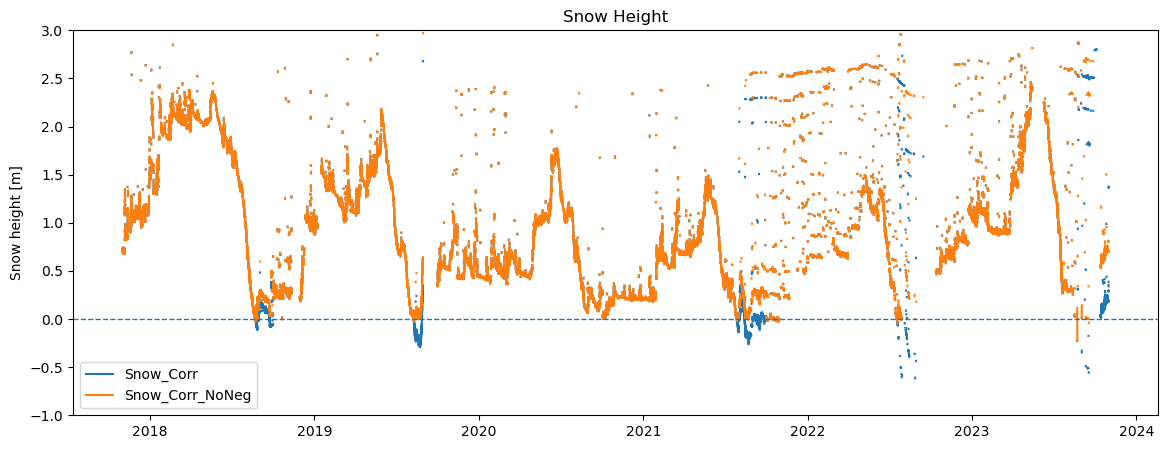

In [11]:
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(ds_CORR.index, ds_CORR.Snow_Avg_Corr, label = 'Snow_Corr')
ax.plot(ds_CORR.index, ds_CORR.Snow_Avg_Corr_NoNeg, label = 'Snow_Corr_NoNeg')
ax.axhline(y=0, linewidth = 1, linestyle = '--')
ax.set_ylim(-1,3)
ax.set_title('Snow Height')
ax.set_ylabel('Snow height [m]')
ax.legend();

### Create datasets

In [13]:
cols = ['RECORD', 'Batt_Min', 'PTemp_Avg', 'Press_Avg',
        'Tair_Avg', 'Tair_Avg_Corr', 'Tair_Avg_Interpol',
        'Hum_Avg', 'Hum_Avg_Corr', 'Hum_Avg_Interpol',
        'SWin_Avg', 'SWout_Avg', 'LWin_Avg', 'LWout_Avg', 'NR01TC_Avg', 'NR01K_Avg', 'Albedo_Avg',
        'SWin_Avg_Corr', 'SWout_Avg_Corr', 'SWout_flag', 'SWin_Avg_Interpol', 'SWout_Avg_Interpol',
        'LWin_Avg_Corr', 'LWout_Avg_Corr', 'LWout_flag', 'LWin_Avg_Interpol', 'LWout_Avg_Interpol', 'Albedo_Avg_Corr',
        'Wspeed', 'Wdir', 'Wspeed_Max', 'Wspeed_Corr', 'Wdir_Corr',
        'Dist_Avg', 'Dist_Avg_Interpol', 'Snow_Avg', 'Snow_Avg_Corr', 'Snow_Avg_Corr_NoNeg', 'Snow_Avg_Interpol', 'Surface'] #,
        # 'EisT1_Avg', 'EisT2_Avg', 'EisT3_Avg', 'EisT4_Avg',
        # 'EisT1_Avg_Corr', 'EisT2_Avg_Corr', 'EisT3_Avg_Corr', 'EisT4_Avg_Corr',
        # 'EisT1_Avg_Interpol', 'EisT2_Avg_Interpol', 'EisT3_Avg_Interpol', 'EisT4_Avg_Interpol']

cols_no_interpol = ['RECORD', 'Batt_Min', 'PTemp_Avg', 'Press_Avg',
        'Tair_Avg', 'Tair_Avg_Corr',
        'Hum_Avg', 'Hum_Avg_Corr',
        'SWin_Avg','SWout_Avg', 'LWin_Avg', 'LWout_Avg', 'NR01TC_Avg', 'NR01K_Avg', 'Albedo_Avg',
        'SWin_Avg_Corr', 'SWout_Avg_Corr', 'SWout_flag', 'LWin_Avg_Corr', 'LWout_Avg_Corr', 'LWout_flag', 'Albedo_Avg_Corr',
        'Wspeed', 'Wdir', 'Wspeed_Max', 'Wspeed_Corr', 'Wdir_Corr',
        'Dist_Avg', 'Snow_Avg', 'Snow_Avg_Corr', 'Snow_Avg_Corr_NoNeg', 'Surface'] #,
        # 'EisT1_Avg', 'EisT2_Avg', 'EisT3_Avg', 'EisT4_Avg',
        # 'EisT1_Avg_Corr', 'EisT2_Avg_Corr', 'EisT3_Avg_Corr', 'EisT4_Avg_Corr']

# reorder columns in dataframe with interpolated variables
ds_CORR = ds_CORR[cols]
# create dataframe without interpolated variables
ds_CORR_nointerpol = ds_CORR[cols_no_interpol]

## 2) Second correction round: unphysical values

In [16]:
ds_dropped = ds_CORR.drop(['Tair_Avg', 'Hum_Avg', 'SWin_Avg', 'SWout_Avg', "LWin_Avg", "LWout_Avg", "Albedo_Avg", "Wspeed",
                      "Wdir", "Snow_Avg", "Snow_Avg_Corr", # "EisT1_Avg", "EisT2_Avg", "EisT3_Avg", "EisT4_Avg",
                      "Tair_Avg_Corr", "Hum_Avg_Corr", "SWin_Avg_Corr", "SWout_Avg_Corr", "LWin_Avg_Corr", "LWout_Avg_Corr"], axis=1)

ds_clean = ds_dropped.rename(columns={"Tair_Avg_Interpol": "Tair", "Hum_Avg_Interpol": "Hum", "SWin_Avg_Interpol": "SWin",
                       "SWout_Avg_Interpol": "SWout", "LWin_Avg_Interpol": "LWin", "LWout_Avg_Interpol": "LWout",
                       "Albedo_Avg_Corr": "Albedo", "Wspeed_Corr": "Wspeed", "Wdir_Corr": "Wdir",
                       "Snow_Avg_Corr_NoNeg": "Snow", "Dist_Avg": "Dist"}) # ,
                       # "EisT1_Avg_Corr": "EisT1", "EisT2_Avg_Corr": "EisT2",
                       # "EisT3_Avg_Corr": "EisT3", "EisT4_Avg_Corr": "EisT4"})
ds_clean['Dist'] = ds_clean.Dist*np.sqrt((ds_clean.Tair+273.15)/273.15)

### Radiation

In [22]:
from astral.sun import sun
from astral import LocationInfo

lat_w = 46.84625000
lon_w = 10.71798889

wss = LocationInfo("Weissseespitze", "Austria", "Europe/Rome", 46.84625000, 10.71798889)

# SWout>SWin

radiation =  ds_clean[['SWin', 'SWout', 'LWin', 'LWout', 'SWout_flag', 'LWout_flag']]
radiation['Albedo'] = radiation.loc[radiation.SWout_flag == 0, 'SWout'] / radiation.loc[radiation.SWout_flag == 0, 'SWin']

# weekly albedo
w_radiation = radiation.resample('W-MON').mean()
radiation['albedo_w'] = w_radiation.Albedo.resample('10min').ffill()
# daily albedo
d_radiation = radiation.resample('24h').mean()
radiation['albedo_d'] = d_radiation.Albedo.resample('10min').ffill()
# 12h
radiation_12h = radiation.resample('12h').mean()
radiation['albedo_12h'] = radiation_12h.Albedo.resample('10min').ffill()
# 8h
radiation_8h = radiation.resample('8h').mean()
radiation['albedo_8h'] = radiation_8h.Albedo.resample('10min').ffill()
# 6h
radiation_6h = radiation.resample('6h').mean()
radiation['albedo_6h'] = radiation_6h.Albedo.resample('10min').ffill()

# 10-14 LT albedo = 8-12 UTC in summer
midday_radiation = radiation.resample('4h').sum()
midday_radiation['Albedo'] = midday_radiation['SWout']/midday_radiation['SWin']
midday_radiation = midday_radiation[midday_radiation.index.hour == 8]
radiation['albedo_midday'] = midday_radiation.Albedo.resample('10min').nearest()

radiation['SWout_albedo'] = radiation['SWout']
radiation['SWin_albedo'] = radiation['SWin']

radiation['SWin_day_flag'] = 0
radiation['SWout_corr'] = radiation['SWout']
radiation['SWout_10-15_corr'] = radiation['SWout']

for ind in radiation.index:
    if (radiation['SWout'][ind] > radiation['SWin'][ind]):
        date = ind.to_pydatetime()
        s = sun(wss.observer, date=datetime.date(date.year, date.month, date.day))
        # AT SUNRISE
        if ((ind.time() > (s['sunrise'] - pd.Timedelta('30min')).time()) and (ind.time() < (s['sunrise'] + pd.Timedelta('3h')).time())):
            radiation['SWout_corr'][ind] = radiation['SWin'][ind] * radiation['albedo_d'][ind]
            radiation['SWout_10-15_corr'][ind] = radiation['SWin'][ind] * radiation['albedo_midday'][ind]

count_sunrise = 0
count_sunset = 0
count_day = 0
count_night = 0

# Apply correction for SWout > SWin

for ind in radiation.index:
    if (radiation['SWout'][ind] > radiation['SWin'][ind]):
        date = ind.to_pydatetime()
        s = sun(wss.observer, date=datetime.date(date.year, date.month, date.day))
        # AT SUNRISE
        if ((ind.time() > (s['sunrise'] - pd.Timedelta('30min')).time()) and (ind.time() < (s['sunrise'] + pd.Timedelta('3h')).time())):
            count_sunrise = count_sunrise + 1
            radiation['SWout_albedo'][ind] = radiation['SWin'][ind] * radiation['albedo_6h'][ind]
            if pd.isna(radiation['albedo_6h'][ind]):
                radiation['SWout_albedo'][ind] = radiation['SWin'][ind] * radiation['albedo_8h'][ind]
                if pd.isna(radiation['albedo_8h'][ind]):
                    radiation['SWout_albedo'][ind] = radiation['SWin'][ind] * radiation['albedo_d'][ind]
                    if pd.isna(radiation['albedo_d'][ind]):
                        # it only happens in february, march and november, then the weekly albedo should be fine as well
                        radiation['SWout_albedo'][ind] = radiation['SWin'][ind] * radiation['albedo_w'][ind]
                        if pd.isna(radiation['albedo_w'][ind]):
                            print(ind)
        # AT SUNSET
        if ((ind.time() > (s['sunset'] - pd.Timedelta('45min')).time()) and (ind.time() < (s['sunset'] + pd.Timedelta('45min')).time())):
            count_sunset = count_sunset + 1
            radiation['SWout_albedo'][ind] = radiation['SWin'][ind] * radiation['albedo_6h'][ind]
            if pd.isna(radiation['albedo_6h'][ind]):
                radiation['SWout_albedo'][ind] = radiation['SWin'][ind] * radiation['albedo_8h'][ind]
                if pd.isna(radiation['albedo_8h'][ind]):
                    radiation['SWout_albedo'][ind] = radiation['SWin'][ind] * radiation['albedo_d'][ind]
                    if pd.isna(radiation['albedo_d'][ind]):
                        radiation['SWout_albedo'][ind] = radiation['SWin'][ind] * radiation['albedo_w'][ind]
                        if pd.isna(radiation['albedo_w'][ind]):
                            print(ind)
        # DURING THE DAY
        if ((ind.time() > (s['sunrise'] + pd.Timedelta('3h')).time()) and (ind.time() < (s['sunset'] - pd.Timedelta('45min')).time())):
            count_day = count_day + 1
            radiation['SWin_day_flag'][ind] = 1
            radiation['SWin_albedo'][ind] = radiation['SWout'][ind] / radiation['albedo_d'][ind + pd.Timedelta('24h')]
            if  pd.isna(radiation['albedo_d'][ind + pd.Timedelta('24h')]):
                # it only happens in february, march and november, then the weekly albedo should be fine as well
                radiation['SWin_albedo'][ind] = radiation['SWout'][ind] / radiation['albedo_w'][ind]
                if pd.isna(radiation['albedo_w'][ind]):
                    print(ind)
                    
print(f'Original errors (all 24h): {len(radiation[radiation.SWin < radiation.SWout])/len(radiation)*100} %')
print(f'Percentage of corrections in the morning: {(count_sunrise/len(radiation))*100} %')
print(f'Percentage of corrections in the evening: {(count_sunset/len(radiation))*100} %')
print(f'Percentage of corrections in the day: {(count_day/len(radiation))*100} %')
print(f'Remaining errors (at night): {len(radiation[radiation.SWin_albedo < radiation.SWout_albedo])/len(radiation)*100} %')

remaining_errors = radiation[['SWin_albedo','SWout_albedo']].loc[radiation.SWout_albedo.values > radiation.SWin_albedo.values]
radiation.loc[remaining_errors.index] = radiation.loc[remaining_errors.index].assign(SWout_albedo=0)
radiation.loc[remaining_errors.index] = radiation.loc[remaining_errors.index].assign(SWin_albedo=0)

C:\Users\Anna\AppData\Local\Temp\ipykernel_25188\1072472466.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  radiation['Albedo'] = radiation.loc[radiation.SWout_flag == 0, 'SWout'] / radiation.loc[radiation.SWout_flag == 0, 'SWin']
C:\Users\Anna\AppData\Local\Temp\ipykernel_25188\1072472466.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  radiation['albedo_w'] = w_radiation.Albedo.resample('10min').ffill()
C:\Users\Anna\AppData\Local\Temp\ipykernel_25188\1072472466.py:19: SettingWithCopyWarning: 
A 

Original errors (all 24h): 9.846784826816776 %
Percentage of corrections in the morning: 4.101374309042041 %
Percentage of corrections in the evening: 1.2487955778690603 %
Percentage of corrections in the day: 2.4560702875399363 %
Remaining errors (at night): 2.1910974187332015 %


In [23]:
# LWin unreliable beacuse of snow
radiation[radiation.SWin_day_flag == 1] = radiation[radiation.SWin_day_flag == 1].assign(LWin = np.NaN)

C:\Users\Anna\AppData\Local\Temp\ipykernel_25188\796894659.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  radiation[radiation.SWin_day_flag == 1] = radiation[radiation.SWin_day_flag == 1].assign(LWin = np.NaN)


In [25]:
# LWout > LWout MAX (due to ice temperature reaching maximum at melting point - 273.15K - and consequent LWout MAX due to Stefan-Boltzmann law)

lwout_overmax = radiation.loc[radiation.LWout_flag == 1, 'LWout'] 

print(f'Erroneous values of LWout: {len(lwout_overmax)/len(radiation.LWout)*100} %')
m_coeff = 15 / 1000
radiation['LWin_offset'] = m_coeff * radiation['SWin_albedo']
radiation['LWout_offset'] = m_coeff * radiation['SWout_albedo']
radiation['LWin_corr'] = radiation['LWin'] - radiation['LWin_offset']
radiation['LWout_corr'] = radiation['LWout'] - radiation['LWout_offset']

lwout_overmax_1 = radiation.LWout_corr[radiation.LWout_corr > 315.6574]
melt_events = radiation.LWout_corr[radiation.LWout_corr >= 315.6574]

print(f'Erroneous values of LWout after SWin correction: {len(lwout_overmax_1)/len(radiation.LWout)*100} %')

radiation['LWout_overmax_flag'] = 0
radiation.loc[radiation['LWout_corr'] > 315.6574] = radiation.loc[radiation['LWout_corr'] > 315.6574].assign(LWout_overmax_flag = 1)
lwout_overmax_1 = lwout_overmax_1.to_frame()

Erroneous values of LWout: 16.24638673360718 %
Erroneous values of LWout after SWin correction: 11.035993204523557 %


C:\Users\Anna\AppData\Local\Temp\ipykernel_25188\2446774600.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  radiation['LWin_offset'] = m_coeff * radiation['SWin_albedo']
C:\Users\Anna\AppData\Local\Temp\ipykernel_25188\2446774600.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  radiation['LWout_offset'] = m_coeff * radiation['SWout_albedo']
C:\Users\Anna\AppData\Local\Temp\ipykernel_25188\2446774600.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

### Snow height

In [26]:
snow = ds_clean[['Snow', 'Dist']]

# 4) Manual corrections to remove extra noise in summer months - calibration matters?

snow[datetime.datetime(2018,10,1,0,30,0):datetime.datetime(2018,11,11,23,50,0)].Snow[snow[datetime.datetime(2018,10,1,0,30,0):datetime.datetime(2018,11,11,23,50,0)].Snow > 0.5] = np.nan
snow[datetime.datetime(2019,11,1,0,10,0):datetime.datetime(2020,3,1,0,0,0)].Snow[snow[datetime.datetime(2019,11,1,0,10,0):datetime.datetime(2020,3,1,0,0,0)].Snow > 0.7] = np.nan
snow[datetime.datetime(2021,8,1,0,10,0):datetime.datetime(2021,12,31,23,50,0)].Snow[snow[datetime.datetime(2021,8,1,0,10,0):datetime.datetime(2021,12,31,23,50,0)].Snow > 0.7] = np.nan
snow[datetime.datetime(2022,1,1,0,10,0):datetime.datetime(2023,2,7,0,0,0)].Snow[snow[datetime.datetime(2022,1,1,0,10,0):datetime.datetime(2023,2,7,0,0,0)].Snow > 1.7] = np.nan
snow[datetime.datetime(2023,2,7,0,0,0):datetime.datetime(2023,10,31,0,0,0)].Snow[snow[datetime.datetime(2023,2,7,0,0,0):datetime.datetime(2023,10,31,0,0,0)].Snow > 2.6] = np.nan
snow[datetime.datetime(2022,1,1,0,10,0):datetime.datetime(2022,2,15,0,0,0)].Snow[snow[datetime.datetime(2022,1,1,0,10,0):datetime.datetime(2022,2,15,0,0,0)].Snow > 0.7] = np.nan

# 5) Compute difference between single obs and daily mean, if bigger than 15 cm remove obs - not realistic

# compute daily snow height
d_snow = snow['Snow'].resample('24h').mean()
snow['snow_d'] = d_snow.resample('10min').ffill()

snow['snow_clean'] = np.nan

for ind in snow.index:
    if (abs(snow['snow_d'][ind] - snow['Snow'][ind]) < 0.15):
        snow['snow_clean'][ind] = snow['Snow'][ind]
    else:
        snow['snow_clean'][ind] = np.nan  

C:\Users\Anna\AppData\Local\Temp\ipykernel_25188\3355700767.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snow[datetime.datetime(2018,10,1,0,30,0):datetime.datetime(2018,11,11,23,50,0)].Snow[snow[datetime.datetime(2018,10,1,0,30,0):datetime.datetime(2018,11,11,23,50,0)].Snow > 0.5] = np.nan
C:\Users\Anna\AppData\Local\Temp\ipykernel_25188\3355700767.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snow[datetime.datetime(2019,11,1,0,10,0):datetime.datetime(2020,3,1,0,0,0)].Snow[snow[datetime.datetime(2019,11,1,0,10,0):datetime.datetime(2020,3,1,0,0,0)].Snow > 0.7] = np.nan
C:\Users\Anna\AppData\Local\Temp\ipyke

In [28]:
ds_final = pd.concat([ds_clean[['RECORD', 'Batt_Min', 'PTemp_Avg', 'Press_Avg', 'Tair', 'Hum', 'NR01TC_Avg',
                     'NR01K_Avg', 'Wspeed_Max', 'Wspeed', 'Wdir', 'Dist']],
           radiation[['Albedo', 'SWout_albedo', 'SWin_albedo', 'SWin_day_flag', 'LWin_corr', 'LWout_corr', 'LWout_overmax_flag']],
           snow['snow_clean']], axis=1)

In [ ]:
# Save to file

data_corr_file = open('20171031-20231031_WSS_Corrected.dat', 'w')

data_corr_file.write('"AWS: Weißseespitze | 3449 m a.s.l. | Longitude: 10°43\'4.76\'\' E, Latitude: 46°50\'46.5\'\' N | 2017-2023"\n')
ds_final.to_csv(data_corr_file, na_rep='nan')
data_corr_file.close()